In [1]:
# Google BQ connector
from google.cloud import bigquery

# Data processing libraries
import pandas as pd
import numpy as np

# Data visualisation tools
import matplotlib.pyplot as plt
from IPython.display import clear_output

# sklearn
from sklearn.cluster import KMeans

# pickle
import pickle

# IPython display
from IPython.display import clear_output

In [5]:
# creating a BQ client
bqclient = bigquery.Client()

In [18]:
query = """
WITH temp_table AS (
  SELECT
    ROUND(rawlat, 3) AS rounded_lat,
    ROUND(rawlng, 3) AS rounded_lng,
    speed,
  FROM
    `jjkoh.grab_raw_singapore`
  WHERE
    speed > 0
)

SELECT
  rounded_lat,
  rounded_lng,
  AVG(speed) as avg_speed,
  MIN(speed) as min_speed,
  MAX(speed) as max_speed,
  APPROX_QUANTILES(speed, 100)[OFFSET(50)] as median_speed,
FROM
  temp_table
GROUP BY
  rounded_lat,
  rounded_lng
"""

In [19]:
df = bqclient.query(query).result().to_dataframe()

In [20]:
df.head()

,rounded_lat,rounded_lng,avg_speed,min_speed,max_speed,median_speed
0,1.290,103.768,13.326175,8.270000,17.417297,13.920000
1,1.245,103.839,11.875188,9.540000,14.650540,11.690000
2,1.433,103.786,5.744561,3.462216,6.813288,5.864194
3,1.418,103.904,6.694544,0.479742,11.858310,8.000000
4,1.415,103.898,14.167949,12.594738,15.937446,14.280000


In [21]:
df.to_pickle("traffic-cluster-speed.pkl")

In [2]:
df = pd.read_pickle("traffic-cluster-speed.pkl")

In [3]:
X = df[['rounded_lat', 'rounded_lng']]
weights = df.median_speed

In [4]:
# calculate distortion for a range of number of cluster
max_nclusters = 32
distortions = [0]*max_nclusters
for i in range(1, max_nclusters):
    print('Calculating distortion with number of cluster {0}/{1}'.format(i, max_nclusters))
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=2020
    )
    km.fit(X, sample_weight=weights)
    distortions[i] = km.inertia_
    clear_output()

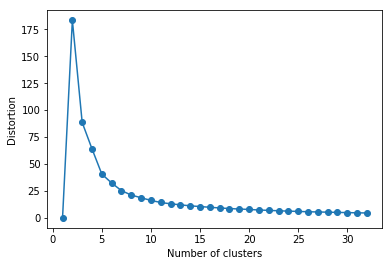

In [5]:
# plot
plt.plot(range(1, max_nclusters + 1), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [6]:
kmeans = KMeans(n_clusters=20, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=2020)
kmeans.fit(X, sample_weight=weights)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=2020, tol=0.0001, verbose=0)

In [7]:
# save kmeans-cluster pickle
with open("models/traffic-cluster-speed-{0}-kmeans.pkl".format(20), "wb") as pkl:
    pickle.dump(kmeans, pkl)

In [8]:
# use cluster_count = 20
with open("models/traffic-cluster-speed-{0}-kmeans.pkl".format(20), "rb") as pkl:
    kmeans = pickle.load(pkl)

In [9]:
df["cluster"] = kmeans.predict(df[["rounded_lat", "rounded_lng"]].values)

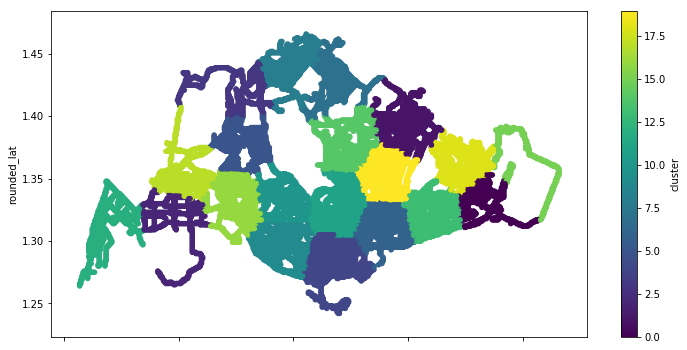

In [10]:
df.plot.scatter(x="rounded_lng", y="rounded_lat", c="cluster", figsize=(12, 6), colormap='viridis')

In [11]:
df.cluster

0        9
1        4
2        8
3        1
4        1
        ..
19534    9
19535    4
19536    9
19537    9
19538    6
Name: cluster, Length: 19539, dtype: int32

In [13]:
import tensorflow as tf
to_categorical = tf.keras.utils.to_categorical

In [25]:
one_hot_encoded = to_categorical(df.cluster, num_classes=20, dtype='uint8')

In [21]:
head = to_categorical(df.cluster, num_classes=20, dtype='uint8')[:5]

In [22]:
head

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=uint8)

In [24]:
head[:, 1]

array([0, 0, 0, 1, 1], dtype=uint8)